<a href="https://colab.research.google.com/github/sahug/time-series/blob/main/TSA%20-%20Basics%20-%20ARIMA%20-%20Timeseries%20Forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**TSA - Basics - Step By Step - Timeseries Forecasting**

In [1]:
import warnings
warnings.filterwarnings("ignore")

**Import Dataset**

In [2]:
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
!kaggle datasets download -d berkeleyearth/climate-change-earth-surface-temperature-data

climate-change-earth-surface-temperature-data.zip: Skipping, found more recently modified local copy (use --force to force download)


**Unzip**

In [4]:
import zipfile
with zipfile.ZipFile("/content/climate-change-earth-surface-temperature-data.zip", "r") as zip:
  zip.extractall("/content/")

**Import Dataset**

In [5]:
import pandas as pd
temp_ds = pd.read_csv("/content/GlobalLandTemperaturesByCity.csv")
temp_ds.head()

,dt,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude
0,1743-11-01,6.068,1.737,Århus,Denmark,57.05N,10.33E
1,1743-12-01,NaN,NaN,Århus,Denmark,57.05N,10.33E
2,1744-01-01,NaN,NaN,Århus,Denmark,57.05N,10.33E
3,1744-02-01,NaN,NaN,Århus,Denmark,57.05N,10.33E
4,1744-03-01,NaN,NaN,Århus,Denmark,57.05N,10.33E


**Data Cleaning and Seggregation**

- Drop Null Data
- Take a data for partuicular country

In [6]:
# Drop Null
temp_ds = temp_ds.fillna(method="ffill")

# Take data for Denmark
ds_denmark = temp_ds[temp_ds.Country == "Denmark"]

# Create Index as Date
ds_denmark.index = pd.to_datetime(ds_denmark.dt)

# Drop columns not needed
ds_denmark = ds_denmark.drop(["dt", "AverageTemperatureUncertainty"], axis=1)

# Describe Data
ds_denmark.describe()

,AverageTemperature
count,12956.000000
mean,7.741228
std,6.597784
min,-7.816000
25%,2.179000
50%,6.904000
75%,14.057000
max,21.437000


In [7]:
ds_denmark.isna().sum()

AverageTemperature    0
City                  0
Country               0
Latitude              0
Longitude             0
dtype: int64

**Visualize**

In [8]:
import matplotlib.pyplot as plt

In [9]:
ts = ds_denmark["AverageTemperature"]
ts

dt
1743-11-01     6.068
1743-12-01     6.068
1744-01-01     6.068
1744-02-01     6.068
1744-03-01     6.068
               ...  
2013-05-01    12.774
2013-06-01    15.685
2013-07-01    18.735
2013-08-01    18.067
2013-09-01    18.067
Name: AverageTemperature, Length: 12956, dtype: float64

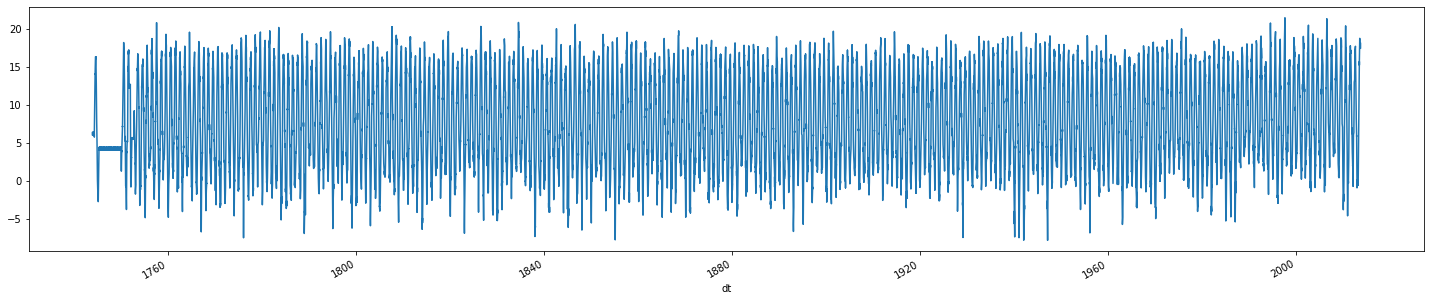

In [10]:
plt.figure(figsize=(25, 5))
ts.plot()

**Test for Stationary**

In [11]:
# %pip uninstall -qq statsmodels
%pip install -qq statsmodels --upgrade

**Augmented Dickey-Fuller Test**

- H0 -> Data is Non-Stationary
- Ha -> Data is Stationary
- p-value < 0.05, reject H0

In [12]:
from statsmodels.tsa.stattools import adfuller

In [13]:
adf = adfuller(ts, autolag="AIC")
print(f"ADF Stats: {adf[0]}")
print(f"P Value: {adf[1]}")

for k, v in adf[4].items():
  print("Critical values:")
  print(f"    {k}, {v}")

ADF Stats: -14.07994112940322
P Value: 2.840513624961441e-26
Critical values:
    1%, -3.430856473618239
Critical values:
    5%, -2.8617638367741463
Critical values:
    10%, -2.566889143372764


As we can see above P Value is less than 0.05 so we can conclude that out data is stationary. 

**ARIMA Model**

In [14]:
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA

In [15]:
import warnings
warnings.filterwarnings("ignore")
# We don't know the best values we will use - 
# Lag = 0, AR = 1 and MA = 1
model = ARIMA(ts, order=(0, 1, 1))
result = model.fit()
pred = result.predict("01/01/1990", "01/01/1991")
pred

dt
1990-01-01     1.883673
1990-02-01     5.252246
1990-03-01     6.160709
1990-04-01     6.732130
1990-05-01     8.620237
1990-06-01    14.731405
1990-07-01    16.060834
1990-08-01    17.167754
1990-09-01    17.498835
1990-10-01    10.357203
1990-11-01     9.017021
1990-12-01     1.964170
1991-01-01     2.787937
Name: predicted_mean, dtype: float64

In [16]:
actual = ds_denmark["01/01/1990": "01/01/1991"]["AverageTemperature"][0:13]
actual

dt
1990-01-01     4.267
1990-02-01     5.895
1990-03-01     6.565
1990-04-01     8.068
1990-05-01    12.944
1990-06-01    15.672
1990-07-01    16.844
1990-08-01    17.402
1990-09-01    12.446
1990-10-01     9.409
1990-11-01     4.027
1990-12-01     2.547
1991-01-01     2.088
Name: AverageTemperature, dtype: float64

In [17]:
from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(actual, pred)
print("MAE: %f" % mae)

MAE: 1.793988
